# Spectrum Analysis
This notebook shows how to do spectral analysis in Python. We begin by importing an audio file.

In [1]:
import numpy as np
import pandas as pd
import pedalboard as pb
import matplotlib.pyplot as plt
import scipy.fft
import scipy.signal

FILE = "D:\\Recording\\Samples\\cello1.wav"
with pb.io.AudioFile(FILE, 'r') as audio_file:
    samples = audio_file.read(audio_file.frames)
    samplerate = audio_file.samplerate

## 1. Compute the spectrum of a slice of an audio file
To compute the spectrum at a particular point in an audio file, you simply run the `scipy.fft.rfft` function. We will take an $M$-point FFT, where $M=4096$ in this case. Since this is a real FFT, only the first $\frac{M+2}{2}$ outputs are valid. This means we have 2049 valid outputs. The first output is the DC bias. The second output is the fundamental frequency, and the remaining 2047 outputs correspond to integer multiples of the fundamental frequency.

In [5]:
FFT_SIZE = 4096
spectrum_point = scipy.fft.rfft(np.reshape(samples[0, 0:FFT_SIZE], (FFT_SIZE)))
print(f"There are {spectrum_point.size} outputs in this real FFT.")
print(spectrum_point)

There are 2049 outputs in this real FFT.
[-1.4825587e+00+0.j          9.1857105e-02+1.4189664j
  4.5314245e+00+0.3291294j  ...  3.3042431e-03+0.00207978j
 -3.8580485e-03-0.0042733j  -1.5258789e-04+0.j        ]


What are the frequencies for these outputs? The frequency corresponding to each $m$, where $0 \leq m \leq \frac{M}{2}$ can be calculated with the formula $$f_m=\frac{mf_s}{M}$$
We can get these frequencies using the `scipy.fft.rfftfreq` function.

In [6]:
freqs = scipy.fft.rfftfreq(FFT_SIZE, 1 / samplerate)
print(freqs)

[0.00000000e+00 1.07666016e+01 2.15332031e+01 ... 2.20284668e+04
 2.20392334e+04 2.20500000e+04]


You'll notice that the outputs of the FFT are complex numbers. Each complex number contains both the magnitude and phase corresponding to the analysis frequency $f_m$. To extract the magnitudes, we use the formula $$|X(m)| = \sqrt{\textrm{Re}(X(m))^2+\textrm{Im}(X(m))^2}$$ and to get the phase, we use the formula $$X_{\phi}(m) = \textrm{atan2}\left({\frac{\textrm{Im}(X(m))}{\textrm{Re}(X(m))}}\right)$$

In [7]:
magnitude_spectrum = np.abs(spectrum_point)
phase_spectrum = np.angle(spectrum_point)
fft_info = pd.DataFrame({"frequencies": freqs, "magnitudes": magnitude_spectrum, "phases": phase_spectrum})
print(fft_info)

       frequencies  magnitudes    phases
0         0.000000    1.482559  3.141593
1        10.766602    1.421937  1.506151
2        21.533203    4.543362  0.072505
3        32.299805    4.461580 -1.996127
4        43.066406    1.476921 -2.081582
...            ...         ...       ...
2044  22006.933594    0.005719 -2.190271
2045  22017.700195    0.000191 -2.399569
2046  22028.466797    0.003904  0.561778
2047  22039.233398    0.005757 -2.305171
2048  22050.000000    0.000153  3.141593

[2049 rows x 3 columns]


It's generally better to use the power spectrum in decibels rather than the magnitude spectrum to represent the magnitudes of the individual FFT bins. To get the power spectrum, we simply square each output FFT magnitude. $$X_{\textrm{power}}(m) = X(m)^2$$
To represent the magnitudes in decibels, we need a reference value that will serve as 0 dB. We will choose the highest bin value in the power spectrum for this. $$x_{\textrm{ref}}=\max_{m \in M}X(m)$$
Then the magnitude of each bin is $$X_{\textrm{power, dB}}(m)=20\log\left(\frac{X_{\textrm{power}}(m)}{x_{\textrm{ref}}}\right)$$

In [8]:
power_spectrum = np.square(magnitude_spectrum)
x_ref = np.max(power_spectrum)
power_spectrum_db = 20 * np.log10(power_spectrum / x_ref)
print(power_spectrum_db)

[ -19.454617  -20.179882    0.       ... -122.63338  -115.88657
 -178.9543  ]


Finally, we'll plot the power spectrum in dB. The full spectrum would take up a lot of space, so we'll only plot the spectrum from 0 to 5000 Hz.

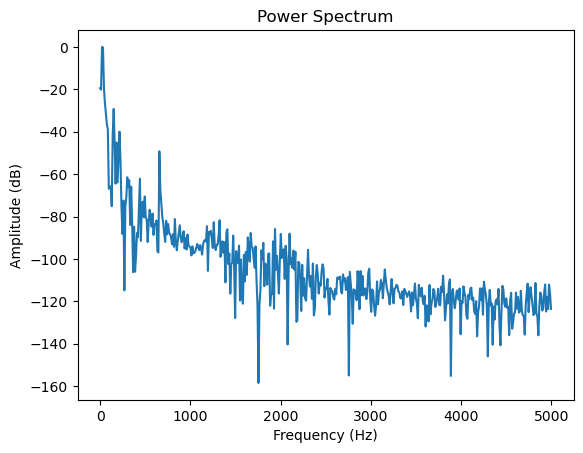

In [9]:
frequency_range = (0, 5000)
new_freqs = []
new_power_spectrum = []
for i in range(freqs.shape[-1]):
    if frequency_range[0] <= freqs[i] <= frequency_range[1]:
        new_freqs.append(freqs[i])
        new_power_spectrum.append(power_spectrum_db[i])
plt.plot(new_freqs, new_power_spectrum)
plt.title(f"Power Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.show()

## 2. Compute the spectrum of an extended chunk of audio
The `rfft` function in `scipy` is only designed to compute the FFT at a specific point in an audio file. To see how the spectrum changes over time, we need to use the STFT. For this, we use the `scipy.signal.stft` function.

In [11]:
WINDOW_SIZE = 4096
STFT = scipy.signal.ShortTimeFFT(np.hanning(WINDOW_SIZE), WINDOW_SIZE // 2, samplerate)
stft_data = STFT.stft(samples[0, :])
magnitude_spectrum = np.abs(stft_data)
phase_spectrum = np.angle(stft_data)
print(magnitude_spectrum)

[[1.66337154e-01 7.87290356e-01 6.95284201e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.42550585e+00 9.52735934e-01 1.58495704e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.26661229e+00 2.82665904e+00 2.20863296e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.22608975e-04 3.40746939e-03 9.20544236e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.92029439e-03 3.79940299e-03 1.20160455e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.37339628e-03 1.85163905e-03 7.31097799e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In the above output, you can see that there are sub arrays with amplitudes for each window along the length of the file. What if we just want to plot the spectrogram of the file? We can use `matplotlib` to plot the spectrogram directly, without taking the STFT first.

Text(0, 0.5, 'Frequency (Hz)')

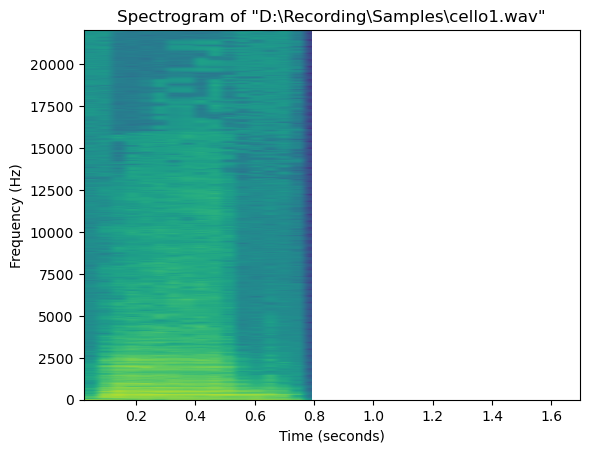

In [13]:
plt.specgram(samples[0, :], NFFT=WINDOW_SIZE, Fs=samplerate, noverlap=WINDOW_SIZE // 2)
plt.title(f"Spectrogram of \"{FILE}\"")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")